In [1]:
import  numpy as np
import pandas as pd
import statsmodels.api as sm

from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeCV

from sklearn.preprocessing import QuantileTransformer, quantile_transform

from sklearn.metrics import median_absolute_error, r2_score
# ....

from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
%matplotlib inline

## Load the data

Let's load the data and have a look at it (make sure you copy the folder FFChallenge_v5 in your working directory). 

In [2]:
# background.csv contains 4,242 rows (one per family) and 13,027 columns
#                index by challengeID: A unique numeric identifier for each child.
#                features: 13,026 background variables asked from birth to age 9, 
#                which you may use in building your model.
background = pd.read_csv('FFChallenge_v5/background.csv', sep=',', header=0,index_col=0)

# train.csv contains 2,121 rows (one per child in the training set) and 7 columns.
train = pd.read_csv('FFChallenge_v5/train.csv', sep=',', header=0, index_col=0)

#constantVariables.txt gives the column names of variables that are constant in the data.
#We recommend that the first step in any analysis be to remove the variables that are constant.
constantVariables = pd.read_csv('FFChallenge_v5/constantVariables.txt',header=None, index_col=0)

/Users/stefan/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (5168,5272,5328,5329,5340,5341,5351,5470,5479,5661,5663,5685,5695,5696,5706,5764,5772,5788,5803,5815,5816,5828,5900,5901,5937,5946,5965,5966,9287,12349,12353,12356) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print(train.shape)
train.head()

(2121, 6)


,gpa,grit,materialHardship,eviction,layoff,jobTraining
challengeID,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,3.50,0.090909,0.0,0.0,0.0
7,2.5,3.25,0.000000,0.0,0.0,0.0
8,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
print(background.shape)
background.head()

(4242, 13026)


,cf1intmon,cf1intyr,cf1lenhr,cf1lenmin,cf1twoc,cf1fint,cf1natsm,f1natwt,cf1natsmx,f1natwtx,...,m4d9,m4e23,f4d6,f4d7,f4d9,m5c6,m5d20,m5k10,f5c6,k5f1
challengeID,,,,,,,,,,,,,,,,,,,,,
1,-3,-3,-9,-9,-3,0,-3,-3,-3,-3,...,6.269946,5.180325,2.511131,1.718804,6.473537,16.369411,4.476881,9.628369,15.981275,24.038266
2,-3,-3,0,40,-3,1,-3,-3,-3,-3,...,6.269946,27.680196,2.511131,1.718804,6.473537,16.369411,26.671897,9.628369,15.981275,3.667679
3,-3,-3,0,45,-3,1,-3,-3,-3,-3,...,6.269946,5.180325,20.867881,24.115867,6.473537,16.369411,4.476881,9.628369,15.981275,24.038266
4,-3,-3,0,45,-3,1,-3,-3,-3,-3,...,6.269946,5.180325,22.018875,22.932641,6.473537,-5.169243,4.476881,9.628369,-6.303171,4.140511
5,-3,-3,-6,50,-3,1,-3,-3,-3,-3,...,6.269946,5.180325,22.916602,22.988036,6.473537,-6.034660,4.476881,9.628369,-6.211828,3.668879


## Cleaning the data

There is a lot of things you can do with regard to cleaning the data. I just show two example and leave the rest to you.

In [5]:
# Drop constant columns
background= background.drop(constantVariables.index.values, axis = 1)

In [6]:
# Lets remove all columns with more than 80% NAs
mask = (background.isna().sum(axis=0)/len(background)<0.8)
background = background[mask[mask].index]
background.head()

,cf1lenhr,cf1lenmin,cf1fint,cf1citsm,f1citywt,f1a2,f1a3,f1a4,f1a4a,f1a5,...,m4d9,m4e23,f4d6,f4d7,f4d9,m5c6,m5d20,m5k10,f5c6,k5f1
challengeID,,,,,,,,,,,,,,,,,,,,,
1,-9,-9,0,-9,-3.000000,-9,-9,-9,-9,-9,...,6.269946,5.180325,2.511131,1.718804,6.473537,16.369411,4.476881,9.628369,15.981275,24.038266
2,0,40,1,1,68.455658,2,1,1,-6,1,...,6.269946,27.680196,2.511131,1.718804,6.473537,16.369411,26.671897,9.628369,15.981275,3.667679
3,0,45,1,1,42.319057,1,1,1,-6,1,...,6.269946,5.180325,20.867881,24.115867,6.473537,16.369411,4.476881,9.628369,15.981275,24.038266
4,0,45,1,1,25.628830,1,1,1,-6,1,...,6.269946,5.180325,22.018875,22.932641,6.473537,-5.169243,4.476881,9.628369,-6.303171,4.140511
5,-6,50,1,1,41.954487,2,1,1,-6,1,...,6.269946,5.180325,22.916602,22.988036,6.473537,-6.034660,4.476881,9.628369,-6.211828,3.668879


You can do more data cleaning:
- What to do about the non-numerical columns?
- Here I just drop them ...

In [7]:
numerical_columns = [c for c,v in background.dtypes.iteritems() if v in [np.float,np.int]]
print('Number of numerical columns %s' % len(numerical_columns))
background = background[numerical_columns]
background.head()

Number of numerical columns 10479


,cf1lenhr,cf1lenmin,cf1fint,cf1citsm,f1citywt,f1a2,f1a3,f1a4,f1a4a,f1a5,...,m4d9,m4e23,f4d6,f4d7,f4d9,m5c6,m5d20,m5k10,f5c6,k5f1
challengeID,,,,,,,,,,,,,,,,,,,,,
1,-9,-9,0,-9,-3.000000,-9,-9,-9,-9,-9,...,6.269946,5.180325,2.511131,1.718804,6.473537,16.369411,4.476881,9.628369,15.981275,24.038266
2,0,40,1,1,68.455658,2,1,1,-6,1,...,6.269946,27.680196,2.511131,1.718804,6.473537,16.369411,26.671897,9.628369,15.981275,3.667679
3,0,45,1,1,42.319057,1,1,1,-6,1,...,6.269946,5.180325,20.867881,24.115867,6.473537,16.369411,4.476881,9.628369,15.981275,24.038266
4,0,45,1,1,25.628830,1,1,1,-6,1,...,6.269946,5.180325,22.018875,22.932641,6.473537,-5.169243,4.476881,9.628369,-6.303171,4.140511
5,-6,50,1,1,41.954487,2,1,1,-6,1,...,6.269946,5.180325,22.916602,22.988036,6.473537,-6.034660,4.476881,9.628369,-6.211828,3.668879


## Splitting the data 

- You should split the data in a train and CV set. 
- Apply any transformation and imputation correctly! Many people do this wrong

In [8]:
X_train, X_CV, y_train, y_CV = train_test_split(background.loc[train.index] , train, test_size=0.33, random_state=42)

Here we replace NAs in the predictors with their population mean (on the training set). 

You can probably do better than this

In [9]:
means_train = X_train.mean()
X_train = X_train.fillna(means_train)
X_CV = X_CV.fillna(means_train)

## Fitting models

The variables we want to pridict are

- Continuous variables: grit, gpa, materialHardship
- Binary variables: eviction, layoff, jobTraining

There are several things you have to consider.

For the continous variables:

- What is the distribution of the response variabel? Is it normal, log-normal or different? Can I use transformations, such as quantile transforms to make modelling it more ameanable?

Binary variable:

- Are there strong class imbalances? How do I deal with them?

### Example

Let's look at one of the variables here. You have to do all 6.

In [10]:
variable = 'gpa'

# Let's drop instances where the response is NA
y_train = y_train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

Let's look a bit more at the response variable

In [11]:
y_train.tail()

challengeID
2434    4.00
911     2.25
3206    2.25
2175    2.50
1679    2.50
Name: gpa, dtype: float64

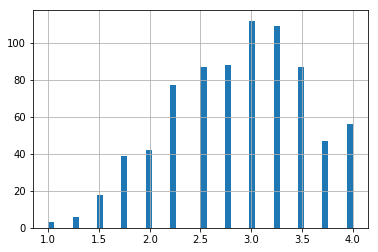

In [12]:
y_train.hist(bins=50)

Not very normal. We can at least rescale it to help make predictions.

In [13]:
y_train_mean = y_train.mean()
y_train_std = y_train.std()

y_train_trans = (y_train-y_train_mean)/y_train_std

Better even, you can also use quantile tansformations to change the shape of the distribution.

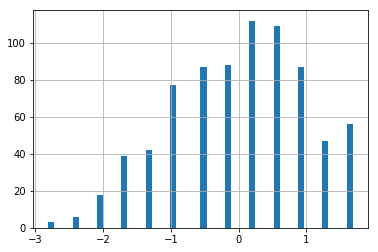

In [14]:
pd.Series(y_train_trans).hist(bins=50)

Let us fit a Lasso model to the transformed data

- How do you choose which model to use?
- What about the hyperparamaters of the model, how do you choose those? Here we just take a fixed value.

In [15]:
model = Lasso(alpha=1000.0,max_iter=10000)
model.fit(X_train, y_train_trans)

Lasso(alpha=1000.0, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

Let's make predictions on the CV set and plot the distribution: 

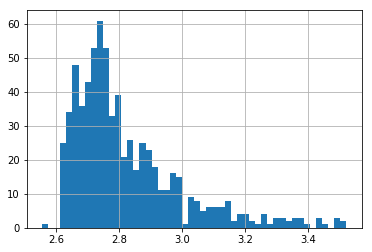

In [16]:
y_pred_trans = model.predict(X_CV)
y_pred = y_train_mean + y_train_std*y_pred_trans
y_pred = np.clip(y_pred,0,None)
pd.Series(y_pred).hist(bins=50)

We can compute the R^2 on the CV set:

In [17]:
y = y_CV[variable]
mask = y.isna()
r2_score(y[~mask],y_pred[~mask])

0.05394944404827606

A Rˆ2 of 5% is not very high, but the data is very noisy (for example, for financial data prediction performance is equally low in the 3% R^2 range). 

In any case, we do better than using the mean as Rˆ2 is positive and this is just a linear model with simple pre-processing and without any hyper-parameter optimisation! You can do better!

Let's now make predictions on the entire data for submission

In [18]:
X = background.fillna(means_train)
y_pred_trans = model.predict(X)
y_pred = y_train_mean + y_train_std*y_pred_trans
y_pred = np.clip(y_pred,0,None)

In [19]:
gpa_predictions = pd.DataFrame(y_pred ,columns = [variable],index=X.index)
gpa_predictions.head()

,gpa
challengeID,
1,2.628665
2,2.828415
3,2.728882
4,2.961724
5,2.709656


## Benchmarks and submission

For the benchmarks we simply take the mean of each continous response variable and the majority class for the binary variables. Given that the classes are highly imbalanced we are actually doing quite well in accuracy.

In [20]:
gpa_benchmark = train['gpa'].mean()
print('gpa mean',gpa_benchmark)
grit_benchmark = train['grit'].mean()
print('grit mean',grit_benchmark)
materialHardship_benchmark = train['materialHardship'].mean()
print('materialHardship mean',materialHardship_benchmark)
x = train['eviction'].dropna()==0
print("No eviction prevalence" , np.sum(x)/len(x))
eviction_benchmark =0
x = train['layoff'].dropna()==0
print("No layoff prevalence" , np.sum(x)/len(x))
layoff_benchmark =0
x = train['jobTraining'].dropna()==0
print("No jobTraining prevalence" , np.sum(x)/len(x))
jobTraining_benchmark =0

gpa mean 2.8667381974248927
grit mean 3.4275387870239773
materialHardship mean 0.10374478160633116
No eviction prevalence 0.9403701165181632
No layoff prevalence 0.7909162098668755
No jobTraining prevalence 0.7652292950034223


We see that the archive provides a sample file for a submission:


In [21]:

prediction = pd.read_csv('FFChallenge_v5/prediction.csv', sep=',', header=0, index_col=0)
prediction.head()

,gpa,grit,materialHardship,eviction,layoff,jobTraining
challengeID,,,,,,
1,2.866738,3.427539,0.103745,0.05963,0.209084,0.234771
2,2.866738,3.427539,0.103745,0.05963,0.209084,0.234771
3,2.866738,3.427539,0.103745,0.05963,0.209084,0.234771
4,2.866738,3.427539,0.103745,0.05963,0.209084,0.234771
5,2.866738,3.427539,0.103745,0.05963,0.209084,0.234771


It's basically our benchmark, but we have set the binary variables to the majority rather than the mean. In the evaluation on the leaderboard it would end up in the same outcome.

In [22]:
prediction['gpa'] = gpa_benchmark
prediction['grit'] = grit_benchmark
prediction['materialHardship'] = materialHardship_benchmark
prediction['eviction'] = eviction_benchmark
prediction['layoff'] = layoff_benchmark
prediction['jobTraining'] = jobTraining_benchmark

In [23]:
prediction.head()

,gpa,grit,materialHardship,eviction,layoff,jobTraining
challengeID,,,,,,
1,2.866738,3.427539,0.103745,0,0,0
2,2.866738,3.427539,0.103745,0,0,0
3,2.866738,3.427539,0.103745,0,0,0
4,2.866738,3.427539,0.103745,0,0,0
5,2.866738,3.427539,0.103745,0,0,0


This is the benchmark you could submit. Let's replace the benchmark for gpa with our prediction:

In [24]:
prediction['gpa'] = gpa_predictions

In [25]:
prediction.head()

,gpa,grit,materialHardship,eviction,layoff,jobTraining
challengeID,,,,,,
1,2.628665,3.427539,0.103745,0,0,0
2,2.828415,3.427539,0.103745,0,0,0
3,2.728882,3.427539,0.103745,0,0,0
4,2.961724,3.427539,0.103745,0,0,0
5,2.709656,3.427539,0.103745,0,0,0


In [26]:
prediction.to_csv('prediction.csv',index=True)